# Описание проекта

Для золотодобывающей компании необходимо предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные (три датасета - тренировочный, тестовый и общий) с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# 1. Подготовка данных

Загрузим все необходимые библиотеки.

In [54]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns
from sklearn.utils import shuffle
import catboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

In [111]:
import warnings
warnings.filterwarnings('ignore')

Загрузим исходные датасеты и запишем их в общий список для удобного обращения.

In [122]:
df_train = pd.read_csv('datasets/gold_recovery_train.csv')
df_test = pd.read_csv('datasets/gold_recovery_test.csv')
df_full = pd.read_csv('datasets/gold_recovery_full.csv')

all_df = [df_train, df_test, df_full]

Просмотрим информацию об исходных таблицах.

In [123]:
for i in all_df:
    print(i.info(5))
    print('='*60)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Полный датасет состоит из 22716 строк (тренировочный и тестовый являются его частями).
Во всех таблицах присутсвуют пропуски. 

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. 

-	C — доля золота в концентрате после флотации/очистки;
-	F — доля золота в сырье/концентрате до флотации/очистки;
-	T — доля золота в отвальных хвостах после флотации/очистки.

In [124]:
def recovery(C, F, T):
    value = (((C * (F - T))) / (F * (C - T))) * 100
    value[value<0] = np.nan
    value[value>100] = np.nan
    return value

In [125]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery_real = df_train['rougher.output.recovery']

Найдём MAE между нашими расчётами и значением признака. 

In [126]:
mean_squared_error(recovery_real.dropna(), recovery(C, F, T).dropna())

2.0435431534920925e-28

Среднее отклонение очень маленькое, поэтому можно считать, что эффективность обогащения рассчитана правильно.

Для удобства дальнейшей работы с данными, приведем наши датасеты в единное пространство индексов, для этого индексируем наши данные по столбцу даты.

In [128]:
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train = df_train.drop(['date'], axis=1)

df_test.index = pd.DatetimeIndex(df_test['date'])
df_test = df_test.drop(['date'], axis=1)

df_full.index = pd.DatetimeIndex(df_full['date'])
df_full = df_full.drop(['date'], axis=1)

Т.к. обработка руды - непрерывный процесс, а датасеты отсортированы по времени, то логично предположить, что в соседних строках данные будут схожими. Поэтому заполним пропуски в данных методом *ffill*.

In [129]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

Проанализируем признаки, недоступные в тестовой выборке. 

Для начала выведем список этих признаков.

In [130]:
df_full.columns[~df_full.columns.isin(df_test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Все отсутствующие в тестовой выборке параметры относятся к параметрам продукта или к расчетным характеристикам.

Создадим набор данных, который в последующем удалим перед обучением модели.

In [131]:
df_new = df_full.drop(df_full.columns[df_full.columns.isin(df_test.columns)], axis=1)

### Вывод.

В качестве исходных данных нам было предоставлено 3 датасета. В них были заполнены пропуски. Проверен расчет эффективности обогащения для этапа флотации. Также датасеты были предварительно подготовлены к последующему обучению моделей.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [133]:
def print_hist(round):
    col_au = round + '.output.concentrate_au'
    col_ag = round + '.output.concentrate_ag'
    col_pb = round + '.output.concentrate_pb'
    
    plt.figure(figsize=[12, 8])
    
    sns.distplot(df_train[col_au], label='Au')
    sns.distplot(df_train[col_ag], label='Ag')
    sns.distplot(df_train[col_pb], label='Pb')
    
    plt.xlabel('Концентрация')
    plt.legend()
    plt.show()

                                Концентрация металлов после флотации


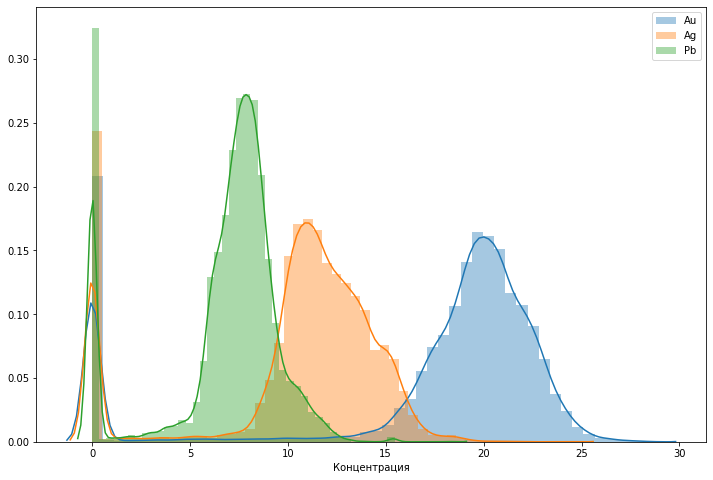

In [134]:
print(' '*32 + 'Концентрация металлов после флотации')
print_hist('rougher')

                           Концентрация металлов после первичной очистки


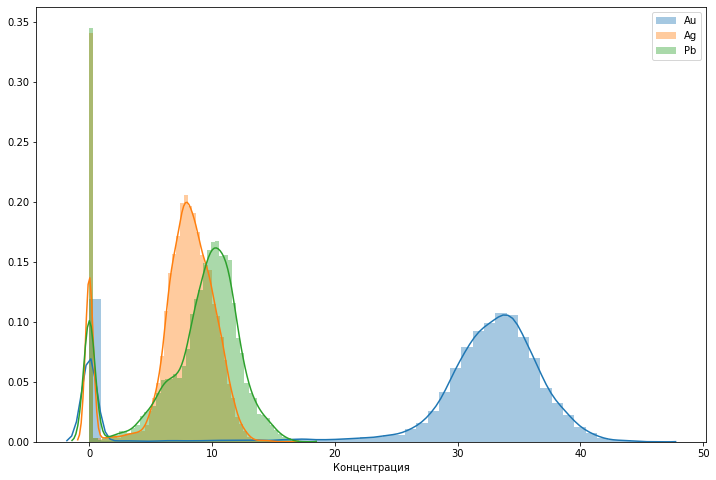

In [135]:
print(' '*27 + 'Концентрация металлов после первичной очистки')
print_hist('primary_cleaner')

                                 Финальная концентрация металлов


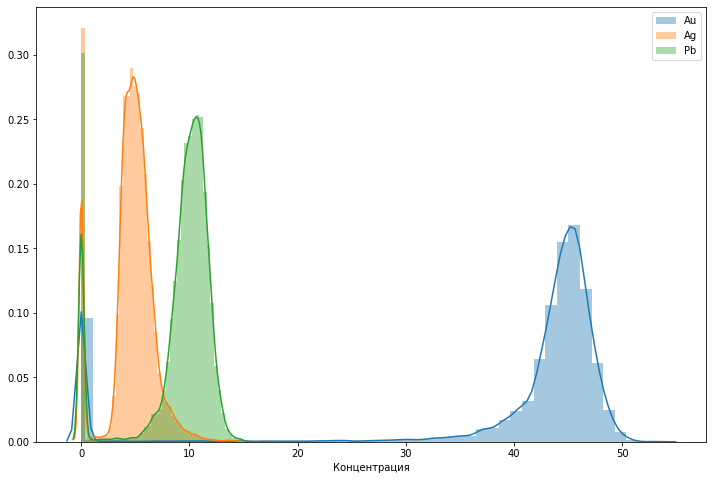

In [136]:
print(' '*33 + 'Финальная концентрация металлов')
print_hist('final')

### Вывод.

По данным графикам можно заметить, как с каждым этапом увеличивается концентрация золота и уменьшается - остальных металлов.

Однако, на всех графиках большое кол-во околонулевых значений, что кажется подозрительным - обработаем их в последующем.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

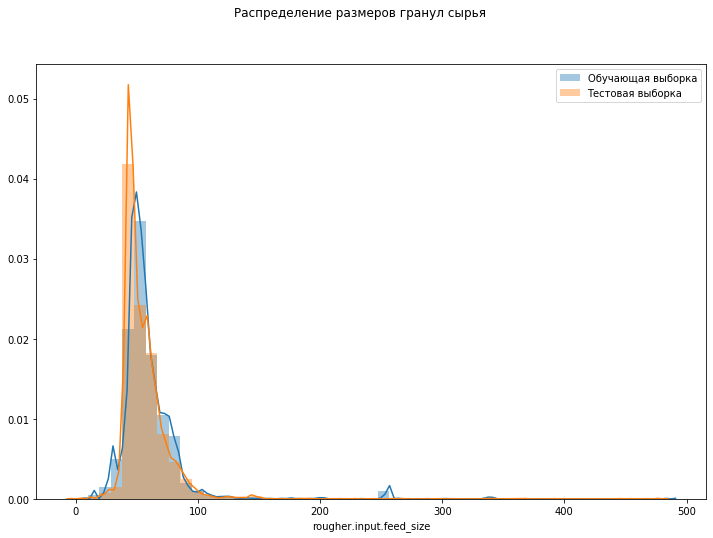

In [137]:
plt.figure(figsize=[12, 8])
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка')
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка')
plt.suptitle('Распределение размеров гранул сырья')
plt.legend()
plt.show()

In [138]:
df_train['rougher.input.feed_size'].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [139]:
df_test['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Распределения размеров гранул сырья близки для обеих выборок, поэтому мы можем позволить обучать и тестировать модель на этих данных.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [140]:
df_train['rougher.concentrate'] = (df_train['rougher.output.concentrate_au'] +
                                  df_train['rougher.output.concentrate_ag'] +
                                  df_train['rougher.output.concentrate_pb'] +
                                  df_train['rougher.output.concentrate_sol'])

df_train['primary_cleaner.concentrate'] = (df_train['primary_cleaner.output.concentrate_au'] +
                                          df_train['primary_cleaner.output.concentrate_ag'] +
                                          df_train['primary_cleaner.output.concentrate_pb'] +
                                          df_train['primary_cleaner.output.concentrate_sol'])

df_train['final.concentrate'] = (df_train['final.output.concentrate_au'] +
                                  df_train['final.output.concentrate_ag'] +
                                  df_train['final.output.concentrate_pb'] +
                                  df_train['final.output.concentrate_sol'])

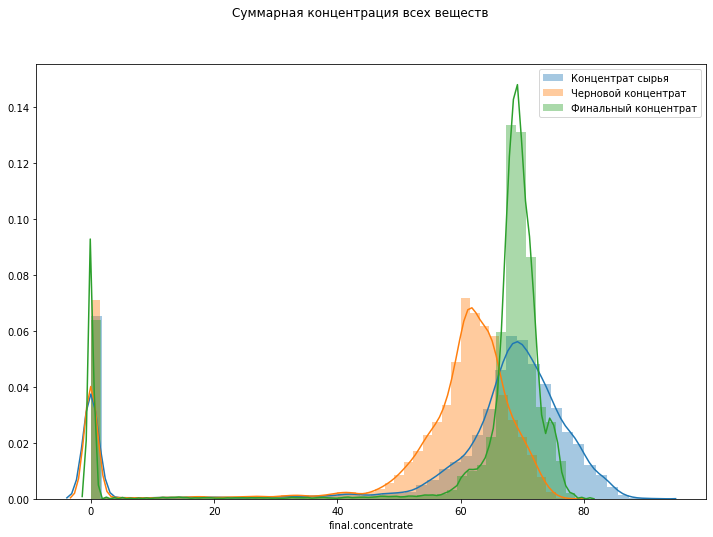

In [141]:
plt.figure(figsize=[12, 8])
sns.distplot(df_train['rougher.concentrate'], label='Концентрат сырья')
sns.distplot(df_train['primary_cleaner.concentrate'], label='Черновой концентрат')
sns.distplot(df_train['final.concentrate'], label='Финальный концентрат')
plt.suptitle('Суммарная концентрация всех веществ')
plt.legend()
plt.show()

Большое кол-во нулевых значений на суммарной концентрации веществ - это те данные, которые явно не помогут в обучении модели, поэтому удалим их.

In [142]:
ind_to_drop = df_train[df_train['final.concentrate'] == 0].index
df_train = df_train.drop(ind_to_drop)

### Вывод.

Проанализировав концентрацию металлов на трех этапах очистки, мы увидели закономерное увеличение концентрации золота и странные околонулевые значения, которые впоследствии были также обнаружены при анализе суммарных концентраций всех веществ. Причиной возникновения этих данных может быть техническая ошибка или это просто попадание бесполезной руды на обогащение (что, вероятно, нужно проверить,  дабы избежать лишних затрат). В любом случае для последующего построения модели нам эти данные не понадобятся.

# 3. Модель

Напишим функцию для вычисления метрики sMAPE:
- Учтем multioutput (рассчет метрики для двух и более столбцов)
- Учтем что формула теряет смысл если в знаменателе 0

In [189]:
def count_smape(y_true, y_pred, multioutput='uniform_average'):
    
    numerator = np.abs(y_true-y_pred)
    denominator =(np.abs(y_true)+np.abs(y_pred))/2
    
    output_errors = np.divide(numerator, denominator)
    
    nonzero_denominator = denominator != 0   
    output_errors[~nonzero_denominator] = 0
    
    output_scores = np.average(output_errors, axis=0)
    
    if multioutput == 'raw_values':
        return output_scores
    elif multioutput == 'uniform_average':
        pass
    return np.average(output_scores) * 100

Для обучения модели по нестандартной метрике создадим свой скорер.

In [169]:
smape_score = make_scorer(count_smape, greater_is_better=False)

Создадим наборы обучающей и тестовой выборки для предсказания rougher.output.recovery.
Для обучающей и тестовой выборки выберим все признаки содержащие rougher в df_test

In [170]:
rougher_columns = df_test.loc[:, df_test.columns.str.contains('rougher')].columns

X_train_rougher = df_train[rougher_columns]
y_train_rougher = df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']]

X_test_rougher = df_test[rougher_columns]
y_test_rougher = df_full[['rougher.output.recovery']].query('index in @df_test.index')

Создадим наборы обучающей и тестовой выборки для предсказания final.output.recovery.
Для обучающей и тестовой выборки выберим все признаки кроме final.output

In [171]:
final_columns = df_full.loc[:, ~df_full.columns.str.contains('final.output')].columns

X_train_final = df_full[final_columns].query('index in @df_train.index')
y_train_final = df_train[['final.output.recovery']]

X_test_final = df_full[final_columns].query('index in @df_test.index')
y_test_final = df_full[['final.output.recovery']].query('index in @df_test.index')

Создадим Pipeline и хэш-таблицу с параметрами для подбора модели

In [218]:
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('model', MultiOutputRegressor(LinearRegression()))])
param_grid = [{'model': [MultiOutputRegressor(LinearRegression())]}, 
               {'model': [MultiOutputRegressor(Ridge())]}, 
               {'model': [MultiOutputRegressor(Lasso())]}, 
               {'model': [MultiOutputRegressor(SGDRegressor())]}, 
               {'model': [MultiOutputRegressor(ElasticNet())]}, 
               {'model': [MultiOutputRegressor(SVR(kernel='poly'))]}, 
               {'model': [MultiOutputRegressor(LinearSVR())]}, 
               {'model': [MultiOutputRegressor(RandomForestRegressor())]}, 
               {'model': [MultiOutputRegressor(XGBRegressor(objective ='reg:squarederror'))]}]

Разобьем данные на 3 фолда для кросс-валидации.

In [219]:
kfold = KFold(n_splits=3)

Начнем подбор модели.

In [220]:
#Модель для rougher
grid_model_rougher = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring=smape_score, n_jobs=-1)

#Модель для final
grid_model_final = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring=smape_score, n_jobs=-1)

Сначала обучим модель для этапа чернового концентрата (rougher).

In [221]:
grid_model_rougher.fit(X_train_rougher, y_train_rougher);

Найдем лучшие параметры:

In [222]:
grid_model_rougher.best_params_

{'model': MultiOutputRegressor(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                          fit_intercept=True,
                                          intercept_scaling=1.0,
                                          loss='epsilon_insensitive',
                                          max_iter=1000, random_state=None,
                                          tol=0.0001, verbose=0),
                      n_jobs=None)}

Оптимальным оказался линейный метод опорных векторов

Получим предсказания

In [223]:
y_pred_array_rougher = pd.DataFrame(grid_model_rougher.predict(X_test_rougher))

In [224]:
С_rougher = y_pred_array_rougher[0]
F_rougher = X_test_rougher['rougher.input.feed_au'].reset_index()
F_rougher = F_rougher.drop('date', axis=1)['rougher.input.feed_au']
T_rougher = y_pred_array_rougher[1]
recovery_rougher_predict = recovery(С_rougher, F_rougher, T_rougher);

In [225]:
y_true_rougher = y_test_rougher.reset_index()
y_true_rougher = y_true_rougher.drop('date', axis=1)['rougher.output.recovery']

In [226]:
rougher_smape = count_smape(y_true_rougher, recovery_rougher_predict.fillna(method='ffill'))
rougher_smape

11.721530541844201

Проведем все те же операции для финального этапа.

In [211]:
grid_model_final.fit(X_train_final, y_train_final);

In [212]:
grid_model_final.best_params_

{'model': MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                        

На этом этапе лучше справилась модель случайного леса.

In [213]:
y_pred_array_final = pd.DataFrame(grid_model_final.predict(X_test_final))

In [214]:
y_pred_array_final = y_pred_array_final[0]
y_true_final = y_test_final.reset_index()
y_true_final = y_true_final.drop('date', axis=1)['final.output.recovery']

In [215]:
final_smape = count_smape(y_true_final, y_pred_array_final)
final_smape

10.001732945871462

Итоговая sMAPE состоит из двух величин:
-	эффективность обогащения чернового концентрата rougher.output.recovery (25%)
-	эффективность обогащения финального концентрата (75%)

In [216]:
smape = rougher_smape*0.25 + final_smape*0.75
print('Итоговая sMAPE:', round(smape, 2))

Итоговая sMAPE: 10.43


*sMAPE = 10.43* - хороший результат, т.к. константная модель выдает больше 12,5.
Более углубленное погружение в тех. процесс, генерация признаков и более тонкая настройка модели позволит нам еще улучшить этот показатель.

# Вывод.

- данные загружены и обработаны, заполнены пропуски;
- проведена проверка расчета эффективности обогащения;
- проведен анализ данных:
    - рассмотрено изменение концентрации металлов на различных этапах очистки;
    - проведено сравнение распределений размеров гранул сырья на обучающей и тестовой выборке;
    - исследована суммарная концентрация всех веществ и удалены аномальные значения;
- построено несколько моделей, ключевой метрикой которых, являлась sMAPE;
- найдены лучшие модели на тестовой выборке для каждого этапа (с учетом кросс-валидации).